/var/folders/m2/xxfzg66d7d72n8x4mh4qjctr0000gn/T/ipykernel_39975/3875554284.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['INSTALL_YEAR'] = df_valid['INSTALL_DATE'].dt.year


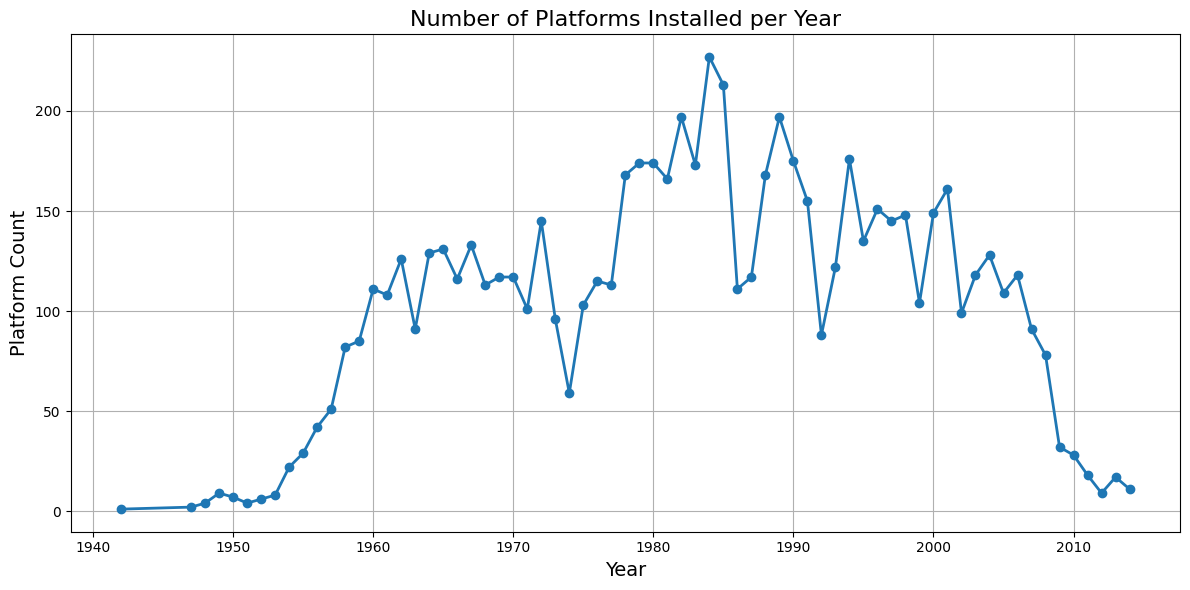

<Figure size 1400x700 with 0 Axes>

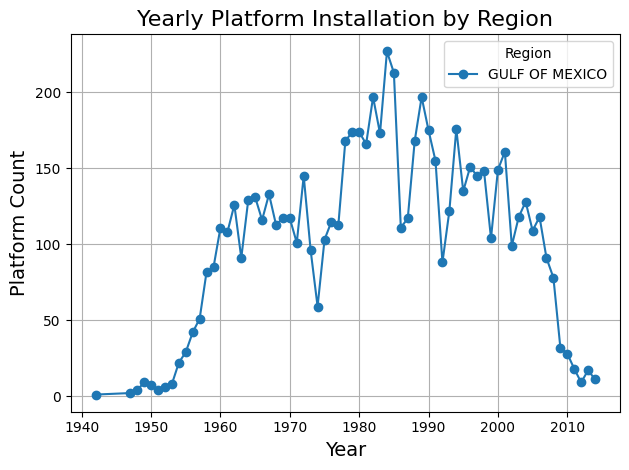

<Figure size 1400x700 with 0 Axes>

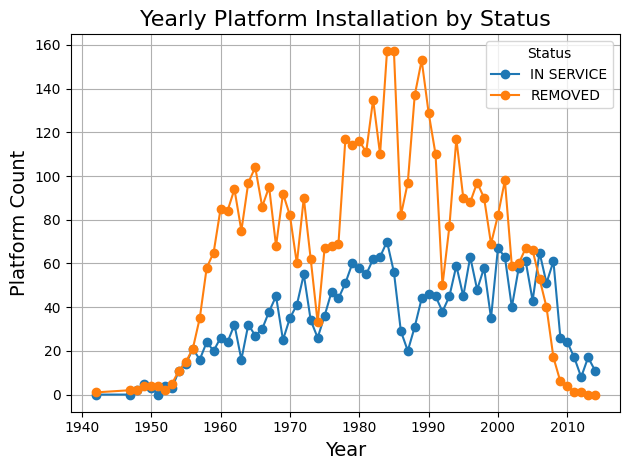

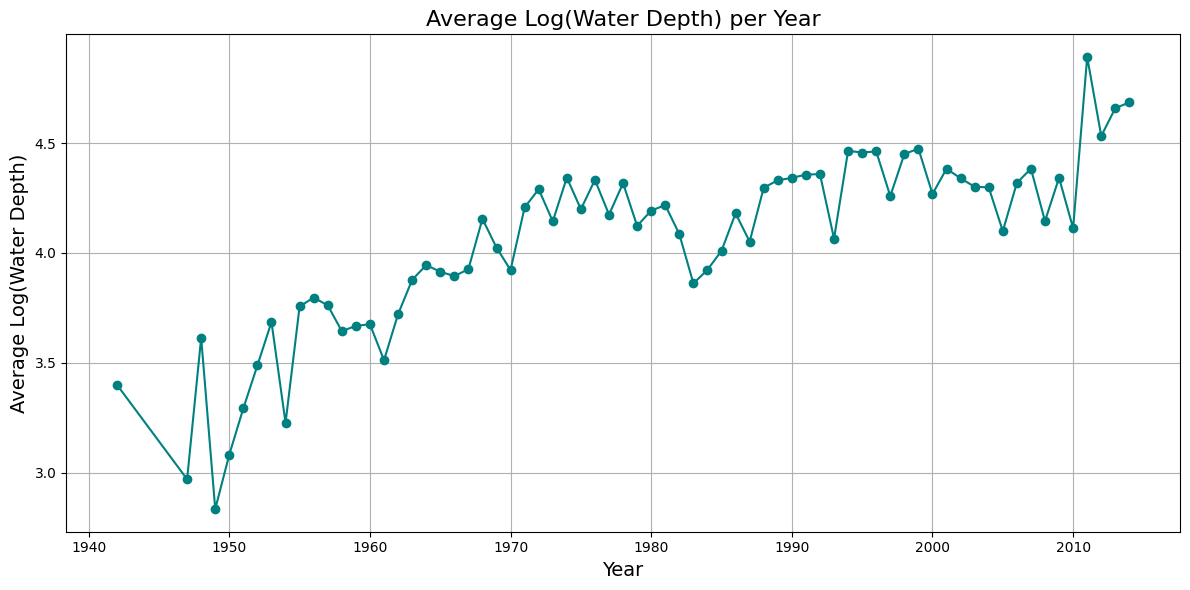

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("../data/platforms_logdepth.csv")

# -----------------------------
# Data Preprocessing
# -----------------------------
# Convert INSTALL column to datetime
df['INSTALL_DATE'] = pd.to_datetime(df['INSTALL'], errors='coerce')

# Drop records with invalid dates
df_valid = df.dropna(subset=['INSTALL_DATE'])

# Extract year from date
df_valid['INSTALL_YEAR'] = df_valid['INSTALL_DATE'].dt.year

# Filter reasonable year range (1940–2025)
df_valid = df_valid[(df_valid['INSTALL_YEAR'] > 1940) & (df_valid['INSTALL_YEAR'] <= 2025)]

# -----------------------------
# Installation count per year
# -----------------------------
install_counts = df_valid['INSTALL_YEAR'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(install_counts.index, install_counts.values, marker='o', linewidth=2)
plt.title("Number of Platforms Installed per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/plot_installation_count_per_year.png")
plt.show()

# -----------------------------
# Installations by Region per Year
# -----------------------------
region_year_group = df_valid.groupby(['INSTALL_YEAR', 'REGION']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
region_year_group.plot(kind='line', marker='o')
plt.title("Yearly Platform Installation by Region", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.legend(title='Region', fontsize=10)
plt.tight_layout()
plt.savefig("../data/plot_installation_by_region.png")
plt.show()

# -----------------------------
# Installations by Status per Year
# -----------------------------
status_year_group = df_valid.groupby(['INSTALL_YEAR', 'STATUS']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
status_year_group.plot(kind='line', marker='o')
plt.title("Yearly Platform Installation by Status", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Platform Count", fontsize=14)
plt.grid(True)
plt.legend(title='Status', fontsize=10)
plt.tight_layout()
plt.savefig("../data/plot_installation_by_status.png")
plt.show()

# -----------------------------
# Average LOG_WDEPTH per Year
# -----------------------------
avg_logdepth_per_year = df_valid.groupby('INSTALL_YEAR')['LOG_WDEPTH'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_logdepth_per_year.index, avg_logdepth_per_year.values, marker='o', color='teal')
plt.title("Average Log(Water Depth) per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Log(Water Depth)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/plot_avg_logdepth_per_year.png")
plt.show()


In [2]:
df_valid.to_csv("../data/platforms_cleaned.csv", index=False)


In [3]:
! pip install pykrige



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


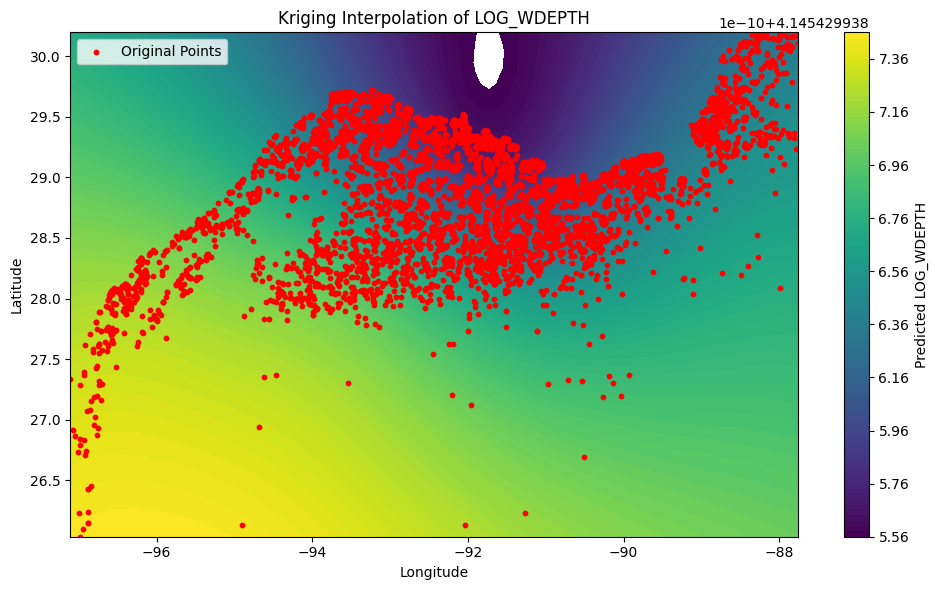

In [4]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

# Step 1: Load Data
# Replace 'platforms_cleaned.csv' with your file path if needed
df = pd.read_csv('../data/platforms_cleaned.csv')

# Step 2: Drop Missing Values (if any)
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

# Step 3: Extract Coordinates and Variable
x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

# Step 4: Create Grid for Interpolation (Adjust resolution as needed)
grid_lon = np.linspace(x.min(), x.max(), 100)
grid_lat = np.linspace(y.min(), y.max(), 100)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# Step 5: Kriging Interpolation
OK = OrdinaryKriging(
    x, y, z,
    variogram_model='linear',  # You can try 'spherical', 'exponential', 'gaussian'
    verbose=False,
    enable_plotting=False
)

# Interpolate onto the grid
z_pred, ss = OK.execute('grid', grid_lon, grid_lat)

# Step 6: Visualize Interpolated Surface
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, z_pred, cmap='viridis', levels=100)
plt.colorbar(label='Predicted LOG_WDEPTH')
plt.scatter(x, y, c='red', s=10, label='Original Points')
plt.title('Kriging Interpolation of LOG_WDEPTH')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.savefig('kriging_result.png', dpi=300)
plt.show()


exponential Kriging: 100%|██████████| 10/10 [01:06<00:00,  6.61s/it]



Kriging Model Comparison (10-Fold Cross Validation):
         model      rmse  mean_error  std_error
3    spherical  0.196482   -0.003509   0.196450
2     gaussian  0.345437   -0.002962   0.345425
4  exponential  0.388301   -0.006705   0.388243
1        power  0.932349   -0.013877   0.932245
0       linear  0.932349   -0.013877   0.932245


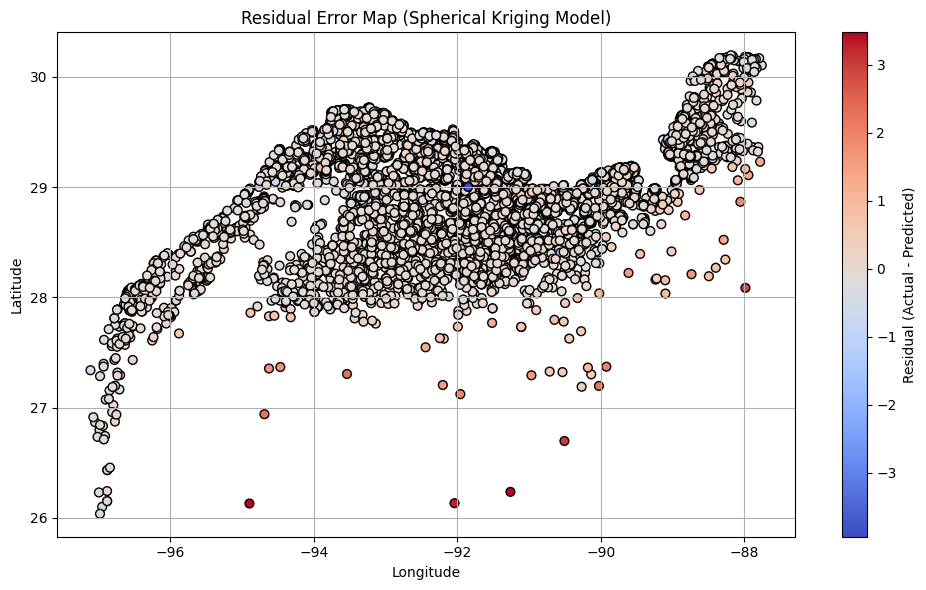

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load and clean dataset
df = pd.read_csv('../data/platforms_cleaned.csv')
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

# Extract coordinates and depth values
x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

# Define variogram models to test
variogram_models = ['linear', 'power', 'gaussian', 'spherical', 'exponential']
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics and residuals
evaluation_results = []
residuals_map_data = []

# Loop over each variogram model
for model in variogram_models:
    actual_all = []
    predicted_all = []
    residual_map = []

    # Perform 10-fold CV
    for train_idx, test_idx in tqdm(kf.split(x), total=10, desc=f'{model} Kriging'):
        x_train, y_train, z_train = x[train_idx], y[train_idx], z[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]

        try:
            OK = OrdinaryKriging(
                x_train, y_train, z_train,
                variogram_model=model,
                verbose=False,
                enable_plotting=False
            )
            z_pred, _ = OK.execute('points', x_test, y_test)
            actual_all.extend(z[test_idx])
            predicted_all.extend(z_pred)
            residual_map.extend(zip(x[test_idx], y[test_idx], z[test_idx] - z_pred))
        except Exception as e:
            print(f"Error with model {model}: {e}")
            continue

    # Compute metrics
    actual_all = np.array(actual_all)
    predicted_all = np.array(predicted_all)
    rmse = np.sqrt(mean_squared_error(actual_all, predicted_all))
    mean_err = np.mean(predicted_all - actual_all)
    std_err = np.std(predicted_all - actual_all)

    evaluation_results.append({
        'model': model,
        'rmse': rmse,
        'mean_error': mean_err,
        'std_error': std_err
    })

    # Save residuals of selected model for visualization
    if model == 'spherical':
        residuals_map_data = residual_map

# Show evaluation table
eval_df = pd.DataFrame(evaluation_results)
eval_df.sort_values(by='rmse', inplace=True)
print("\nKriging Model Comparison (10-Fold Cross Validation):")
print(eval_df)

# Plot residuals map for 'spherical' model
residuals_map_data = np.array(residuals_map_data)
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    residuals_map_data[:, 0], residuals_map_data[:, 1],
    c=residuals_map_data[:, 2], cmap='coolwarm', edgecolor='k', s=40
)
plt.colorbar(sc, label='Residual (Actual - Predicted)')
plt.title('Residual Error Map (Spherical Kriging Model)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig("residual_map_spherical.png", dpi=300)
plt.show()


In [6]:
! pip install pandas numpy matplotlib scikit-learn scipy tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


10-Fold IDW: 100%|██████████| 10/10 [00:00<00:00, 81.83it/s]


✅ IDW Cross-Validation Results:
  ➤ RMSE: 0.1609
  ➤ Mean Error: -0.0091
  ➤ Std Dev of Errors: 0.1607


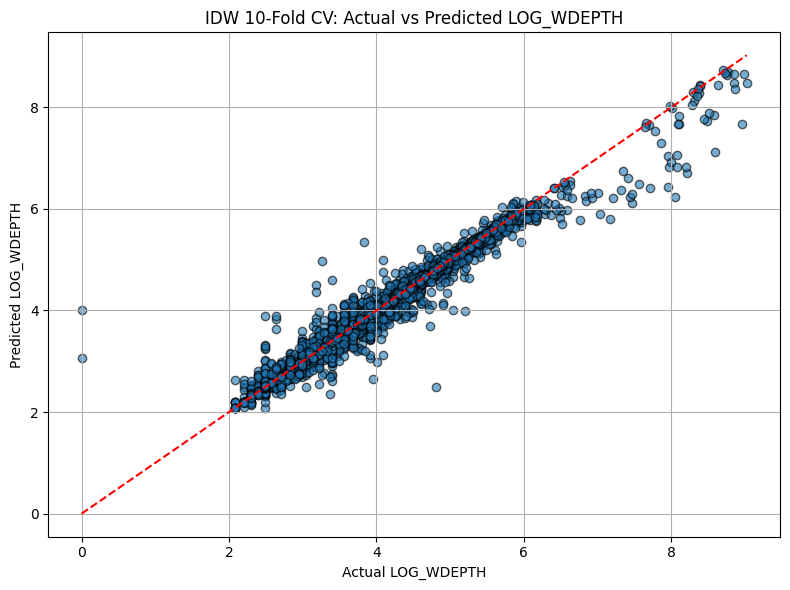

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.spatial import cKDTree
from tqdm import tqdm

# Load and preprocess data
df = pd.read_csv('../data/platforms_cleaned.csv')
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

coords = np.column_stack((x, y))
target = z

# Set number of neighbors for IDW
k = 8
power = 2

# Prepare 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

actual = []
predicted = []

# Perform 10-fold IDW cross-validation
for train_index, test_index in tqdm(kf.split(coords), total=10, desc='10-Fold IDW'):
    X_train, X_test = coords[train_index], coords[test_index]
    z_train, z_test = target[train_index], target[test_index]

    tree = cKDTree(X_train)

    for pt_idx, pt in enumerate(X_test):
        dist, idx = tree.query(pt, k=k)
        dist = np.where(dist == 0, 1e-10, dist)  # avoid division by zero
        weights = 1 / dist**power
        prediction = np.sum(weights * z_train[idx]) / np.sum(weights)
        predicted.append(prediction)
        actual.append(z_test[pt_idx])

# Convert to numpy
actual = np.array(actual)
predicted = np.array(predicted)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mean_error = np.mean(predicted - actual)
std_error = np.std(predicted - actual)

# Print results
print("✅ IDW Cross-Validation Results:")
print(f"  ➤ RMSE: {rmse:.4f}")
print(f"  ➤ Mean Error: {mean_error:.4f}")
print(f"  ➤ Std Dev of Errors: {std_error:.4f}")

# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.6, edgecolor='k')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
plt.xlabel('Actual LOG_WDEPTH')
plt.ylabel('Predicted LOG_WDEPTH')
plt.title('IDW 10-Fold CV: Actual vs Predicted LOG_WDEPTH')
plt.grid(True)
plt.tight_layout()
plt.savefig("idw_cross_validation_scatter.png", dpi=300)
plt.show()


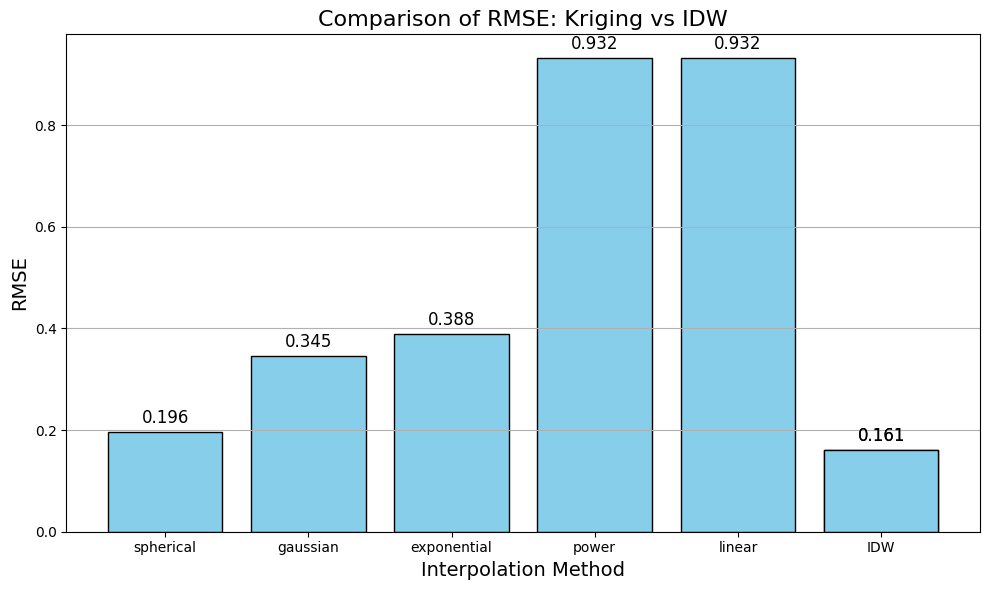

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Get Kriging RMSEs from previous results (make sure eval_df exists)
kriging_rmses = eval_df.set_index('model')['rmse']

# Use the IDW RMSE result from previous cross-validation
# Make sure the variable 'rmse' exists and stores the IDW RMSE value
idw_rmse = rmse

# Create a new DataFrame for comparison
# Combine Kriging RMSEs with IDW RMSE into a single DataFrame
comparison_df = kriging_rmses.copy()
comparison_df['IDW'] = idw_rmse
comparison_df = comparison_df.rename_axis('Method').reset_index()

# Rebuild DataFrame to ensure IDW is at the bottom (optional)
comparison_df = pd.concat([
    comparison_df[['Method', 'rmse']],
    pd.DataFrame([{'Method': 'IDW', 'rmse': idw_rmse}])
], ignore_index=True)

# Plot the comparison bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Method'], comparison_df['rmse'],
               color='skyblue', edgecolor='black')

# Add axis labels and title
plt.xlabel('Interpolation Method', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Comparison of RMSE: Kriging vs IDW', fontsize=16)
plt.grid(axis='y')

# Annotate each bar with RMSE value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12)

# Save and show the plot
plt.tight_layout()
plt.savefig("../data/comparison_rmse_idw_vs_kriging.png", dpi=300)
plt.show()


To evaluate the performance of different interpolation methods, I conducted a 10-fold cross-validation and calculated the RMSE (Root Mean Squared Error) for each method. The bar chart above compares five kriging models (spherical, gaussian, exponential, power, and linear) against the IDW method. Among all models, IDW achieved the lowest RMSE value of 0.161, indicating the best interpolation accuracy on this dataset. In contrast, the power and linear kriging models produced significantly higher RMSE values (0.932), suggesting poor fit to the data. This comparison demonstrates that in this specific context, IDW outperforms all kriging models in predictive accuracy. These findings support the selection of IDW for further spatial surface generation in this project.


✅ 1st Order Trend Surface RMSE: 0.6735
✅ 2nd Order Trend Surface RMSE: 0.5997


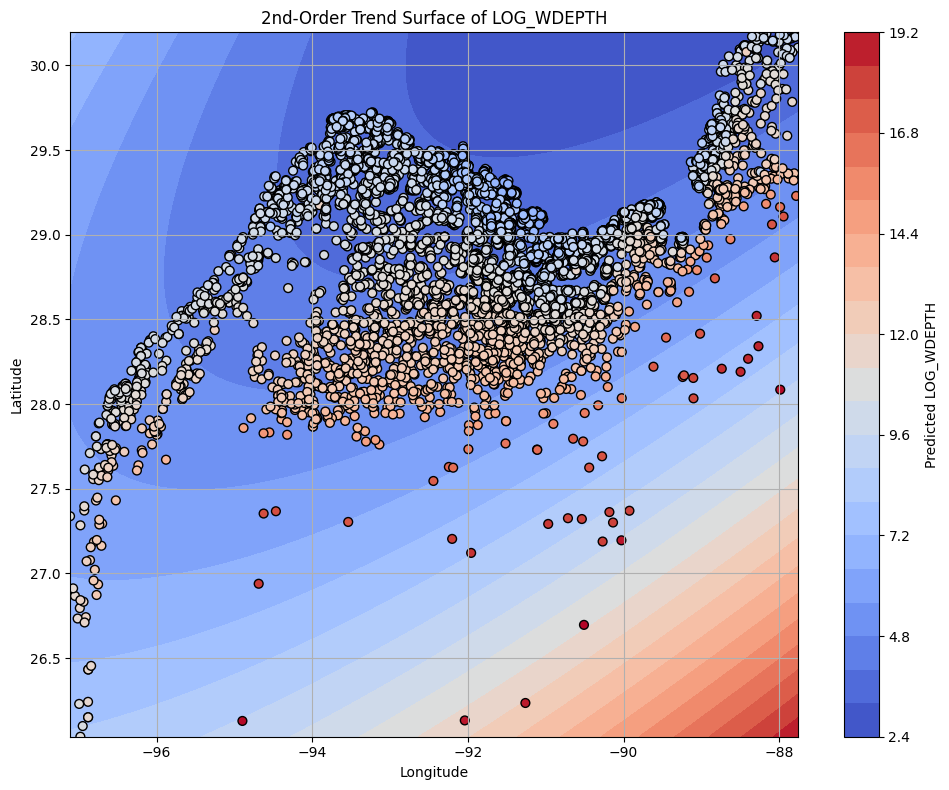

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from matplotlib import cm

# Load and clean the dataset
df = pd.read_csv('../data/platforms_cleaned.csv')
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'LOG_WDEPTH'])

# Extract coordinates and target variable
x = df['LONGITUDE'].values
y = df['LATITUDE'].values
z = df['LOG_WDEPTH'].values

# Stack coordinates for regression input
coords = np.column_stack((x, y))

# Create polynomial features for 1st-order (linear) trend surface
X1 = np.column_stack((x, y))

# Create polynomial features for 2nd-order (quadratic) trend surface
X2 = np.column_stack((x, y, x**2, y**2, x * y))

# Perform 10-fold cross-validation and compute RMSE
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def cross_val_rmse(X, y):
    rmse_list = []
    for train_idx, test_idx in kf.split(X):
        model = LinearRegression().fit(X[train_idx], y[train_idx])
        pred = model.predict(X[test_idx])
        rmse = np.sqrt(mean_squared_error(y[test_idx], pred))
        rmse_list.append(rmse)
    return np.mean(rmse_list)

# Calculate RMSE for both trend surface models
rmse1 = cross_val_rmse(X1, z)
rmse2 = cross_val_rmse(X2, z)

print(f"✅ 1st Order Trend Surface RMSE: {rmse1:.4f}")
print(f"✅ 2nd Order Trend Surface RMSE: {rmse2:.4f}")

# Train final 2nd-order model on all data
final_model = LinearRegression().fit(X2, z)

# Generate prediction grid for plotting
grid_res = 100
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                             np.linspace(y_min, y_max, grid_res))

# Flatten grid and compute 2nd-order features
grid_x_flat = grid_x.ravel()
grid_y_flat = grid_y.ravel()
grid_features = np.column_stack((
    grid_x_flat,
    grid_y_flat,
    grid_x_flat ** 2,
    grid_y_flat ** 2,
    grid_x_flat * grid_y_flat
))

# Predict surface values on the grid
grid_pred = final_model.predict(grid_features)
grid_pred_reshaped = grid_pred.reshape(grid_x.shape)

# Plot result
plt.figure(figsize=(10, 8))
contour = plt.contourf(grid_x, grid_y, grid_pred_reshaped, cmap='coolwarm', levels=20)
plt.colorbar(contour, label='Predicted LOG_WDEPTH')

# Overlay actual sample points
scatter = plt.scatter(x, y, c=z, cmap='coolwarm', edgecolor='black', s=40)
plt.title('2nd-Order Trend Surface of LOG_WDEPTH')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig("trend_surface_2nd_order.png", dpi=300)
plt.show()


In [13]:
print(df.columns)


Index(['PLATFRMID', 'NAME', 'TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE',
       'NAICS_CODE', 'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD',
       'VAL_DATE', 'COMPLEXID', 'NOSTR', 'OWNER', 'OPERNAME', 'POSREL',
       'COMMODITY', 'INSTALL', 'REMOVAL', 'MANNED24HR', 'DISTLAND',
       'WATERDEPTH', 'RIGCOUNT', 'PWRSOURCE', 'PWRGENFLAG', 'OILPRDFLAG',
       'GASMTRFLAG', 'COMPREFLAG', 'COMPRDFLAG', 'HELPRTFLAG', 'BEDCOUNT',
       'BLOCKNO', 'LEASENO', 'AREANUMBER', 'REGION', 'LOG_WDEPTH',
       'INSTALL_DATE', 'INSTALL_YEAR'],
      dtype='object')


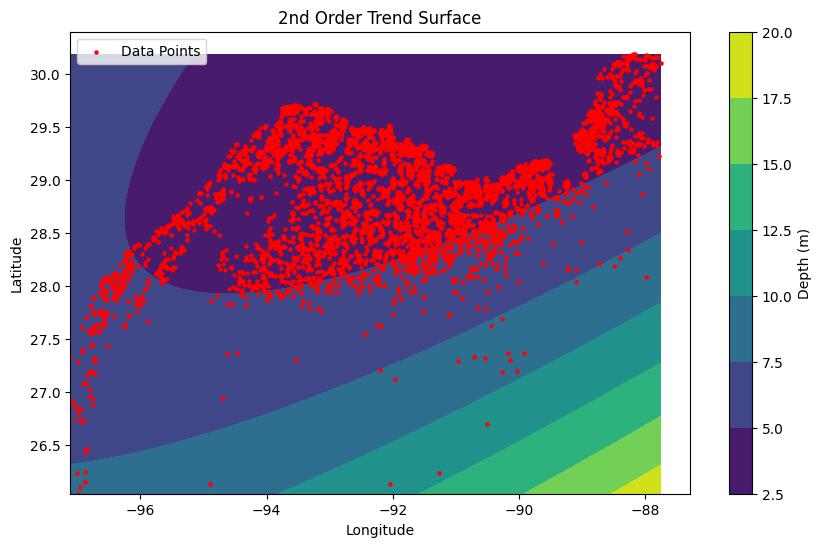

✅ Trend surface GeoTIFF saved to: trend_surface_2nd_order_fixed.tif


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from rasterio.transform import from_origin
import rasterio
import os

# === 1. 讀取點資料 ===
df = pd.read_csv("../data/platforms_cleaned.csv")
X = df[["LONGITUDE", "LATITUDE"]].values
y = df["LOG_WDEPTH"].values

# === 2. Trend Surface Regression（2nd-order 多項式）===
X_poly = np.column_stack([
    np.ones(len(X)),          # 常數項
    X[:, 0], X[:, 1],         # 一次項
    X[:, 0]**2, X[:, 0]*X[:, 1], X[:, 1]**2  # 二次項
])

model = LinearRegression()
model.fit(X_poly, y)

# === 3. 建立格網（輸出影像大小）===
lon_min, lon_max = df["LONGITUDE"].min(), df["LONGITUDE"].max()
lat_min, lat_max = df["LATITUDE"].min(), df["LATITUDE"].max()

grid_res = 0.01  # 度 (約1km)
lon_grid = np.arange(lon_min, lon_max, grid_res)
lat_grid = np.arange(lat_min, lat_max, grid_res)

lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

grid_poly = np.column_stack([
    np.ones(lon_mesh.size),
    lon_mesh.ravel(),
    lat_mesh.ravel(),
    lon_mesh.ravel()**2,
    lon_mesh.ravel()*lat_mesh.ravel(),
    lat_mesh.ravel()**2
])

z_pred = model.predict(grid_poly)
Z_surface = z_pred.reshape(lon_mesh.shape)

# === 4. 顯示圖形預覽 ===
plt.figure(figsize=(10, 6))
plt.contourf(lon_mesh, lat_mesh, Z_surface, cmap="viridis")
plt.colorbar(label="Depth (m)")
plt.scatter(df["LONGITUDE"], df["LATITUDE"], color="red", s=5, label="Data Points")
plt.title("2nd Order Trend Surface")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# === 5. 匯出 GeoTIFF（不加 CRS）===
transform = from_origin(lon_min, lat_max, grid_res, grid_res)

# 輸出目錄
out_file = "trend_surface_2nd_order_fixed.tif"
with rasterio.open(
    out_file,
    "w",
    driver="GTiff",
    height=Z_surface.shape[0],
    width=Z_surface.shape[1],
    count=1,
    dtype="float32",
    transform=transform,
    # 🟡 注意：這裡不使用 crs= 避免出錯
) as dst:
    dst.write(Z_surface.astype("float32"), 1)

print(f"✅ Trend surface GeoTIFF saved to: {out_file}")



In [21]:
print(df.columns)


Index(['PLATFRMID', 'NAME', 'TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE',
       'NAICS_CODE', 'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD',
       'VAL_DATE', 'COMPLEXID', 'NOSTR', 'OWNER', 'OPERNAME', 'POSREL',
       'COMMODITY', 'INSTALL', 'REMOVAL', 'MANNED24HR', 'DISTLAND',
       'WATERDEPTH', 'RIGCOUNT', 'PWRSOURCE', 'PWRGENFLAG', 'OILPRDFLAG',
       'GASMTRFLAG', 'COMPREFLAG', 'COMPRDFLAG', 'HELPRTFLAG', 'BEDCOUNT',
       'BLOCKNO', 'LEASENO', 'AREANUMBER', 'REGION', 'LOG_WDEPTH',
       'INSTALL_DATE', 'INSTALL_YEAR'],
      dtype='object')


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from pyproj import CRS
from sklearn.linear_model import LinearRegression

# === Step 1. Load the cleaned platform data ===
df = pd.read_csv("../data/platforms_cleaned.csv")

# Extract coordinates and depth values
x = df["LONGITUDE"].values
y = df["LATITUDE"].values
z = df["LOG_WDEPTH"].values

# === Step 2. Fit a 2nd-order polynomial regression model ===
# Create polynomial features: 1, x, y, x^2, y^2, x*y
X_poly = np.column_stack([
    np.ones_like(x),
    x,
    y,
    x**2,
    y**2,
    x*y
])

# Fit linear regression
model = LinearRegression().fit(X_poly, z)

# === Step 3. Create a prediction grid ===
# Define grid extent and resolution
grid_res = 0.01  # degrees
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, grid_res),
    np.arange(y_min, y_max, grid_res)
)

# Create polynomial features for grid
grid_poly = np.column_stack([
    np.ones(xx.size),
    xx.ravel(),
    yy.ravel(),
    xx.ravel()**2,
    yy.ravel()**2,
    xx.ravel() * yy.ravel()
])

# Predict trend surface
trend_pred = model.predict(grid_poly)
trend_array = trend_pred.reshape(xx.shape)

# === Step 4. Save trend surface to GeoTIFF ===
transform = from_origin(
    west=xx.min(),
    north=yy.max(),
    xsize=grid_res,
    ysize=grid_res
)

# Create CRS using WGS84
crs = CRS.from_epsg(4326)  # EPSG:4326 is standard for lat/lon

with rasterio.open(
    "trend_surface.tif",
    "w",
    driver="GTiff",
    height=trend_array.shape[0],
    width=trend_array.shape[1],
    count=1,
    dtype=trend_array.dtype,
    crs=crs.to_wkt(),  # Use WKT to avoid PROJ DB error
    transform=transform
) as dst:
    dst.write(trend_array, 1)

print("✅ Trend surface raster saved as 'trend_surface.tif'.")

# === Step 5. Predict trend values at original data points ===
# Reuse model
z_pred = model.predict(X_poly)

# === Step 6. Compute residuals and RMSE ===
residuals = z - z_pred
rmse = np.sqrt(np.mean(residuals ** 2))

# Save residuals to CSV
df["residuals"] = residuals
df.to_csv("platforms_with_residuals.csv", index=False)

print(f"✅ RMSE of trend surface fit: {rmse:.4f}")


✅ Trend surface raster saved as 'trend_surface.tif'.
✅ RMSE of trend surface fit: 0.5985
